# Team 147 Final project - A Replication on CNN-DDI: a learning-based method for predicting drug–drug interactions using convolution neural networks

Team member: Yunchang Pang

Video Link: https://drive.google.com/file/d/1qNX8f9NiMzU_hE8zR0K8xTs-7mi0IEq3/view?usp=sharing

Github Link: https://github.com/ycpang5/598HCFP

# Introduction
Drug-drug interactions (DDIs) are critical considerations in pharmaceutical development and clinical practice, as they can significantly alter a drug's effectiveness and safety. Predicting these interactions accurately is vital for preventing adverse effects and ensuring patient safety. Traditionally, DDI prediction has relied on manual testing and database reviews, which are time-consuming and cannot cover all potential interaction scenarios. Recent advances have leveraged computational models to predict DDIs more efficiently and comprehensively.

The paper "CNN-DDI: a learning-based method for predicting drug–drug interactions using convolution neural networks" introduces a novel approach that employs convolutional neural networks (CNNs) to predict DDIs. Unlike traditional methods, this approach utilizes a combination of drug feature extraction and advanced machine learning techniques to enhance prediction accuracy. The CNN-DDI model consists of two primary components:

*   Feature Selection Module: This module selects and combines various drug features into a format suitable for neural network processing, using techniques like Jaccard similarity to evaluate the correlation between drugs based on their properties.
*   CNN-based Prediction Module: This module employs a deep learning architecture to analyze the processed features and predict potential interactions. The architecture includes multiple convolutional layers that capture both local and global feature interactions, which are crucial for understanding complex drug relationships.

The CNN-DDI model marks a significant advancement in the field of bioinformatics by introducing a method that not only predicts DDIs with high accuracy but also handles the vast and complex nature of pharmaceutical data more effectively than traditional models. By implementing and testing this model, it has shown robustness across various metrics such as accuracy, precision, and recall, particularly excelling in scenarios where conventional models struggle. The approach demonstrates how deep learning can be adapted to specific and critical problems in healthcare, offering a promising direction for future research and application.

This paper's contributions are particularly valuable for pharmaceutical research and healthcare applications, where understanding and predicting DDIs can directly influence patient treatment outcomes and drug development processes. By advancing how we predict DDIs, the research opens up new possibilities for safer medication practices and more effective drug use in clinical settings.

# Scope of Reproducibility

The original paper claims that the CNN-DDI model outperforms conventional models (RF, GBDT, KNN, LR) and another NN model (DDIMDL) in predicting drug-drug interactions. This study aims to replicate these findings and confirm the superiority of CNN-DDI over other models. The reproducibility scope includes the following hypotheses and experiments:


1.   Hypothesis 1: CNN-DDI outperforms traditional models in accuracy, precision, recall, F1-score, and AUC.

  *  Experiment 1: Compare the performance metrics (accuracy, precision, recall, F1-score, and AUC) of CNN-DDI against traditional models (RF, GBDT, KNN, LR) using the same dataset and evaluation criteria as the original study.


2.   Hypothesis 2 CNN-DDI outperforms DDIMDL in predicting DDI events, using the same features.

  *  Experiment 2: Compare CNN-DDI and DDIMDL using the same set of features to ascertain which model provides better performance across standard metrics (accuracy, AUPR, AUC, F1, precision, recall). This comparison directly tests the claim of CNN-DDI's superiority over other advanced models in the field.



# Methodology


In [1]:
%%capture
!git clone https://github.com/YifanDengWHU/DDIMDL.git
%cd DDIMDL

In [2]:
import sqlite3
import pandas as pd
from numpy.random import seed
seed(1)
import csv
import sqlite3
import time
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Model
from keras.layers import Dense, Dropout, Input, Activation, BatchNormalization
from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.layers import Conv1D, Add, Flatten

In [3]:
event_num = 65
droprate = 0.3
vector_size = 572

##  Data

Source of the Data:

The dataset used in this study was originally created for the paper "A multimodal deep learning framework for predicting drug-drug interaction events." It classifies DDIs into 65 distinct types, providing a detailed approach beyond merely identifying interactions. This dataset encompasses 572 drugs and 74,528 DDI-associated events, which were meticulously gathered from DrugBank version 5.1.3, a reliable and manually curated database offering extensive drug information and a unified format for DDI descriptions.

Statistics:

* Drugs: The dataset comprises 572 unique drugs, each characterized by multiple pharmacological attributes.
* Events: There are 37,264 documented interactions between the drugs, each described through multiple attributes including the mechanism and action of interaction.
* Extraction: This dataset represents the results of applying NLP techniques to raw data, transforming each interaction into a tuple format: {mechanism, action, drugA, drugB}.
* Event Numbers: The dataset also includes a listing of the types of DDI events and their frequency of occurrence.

Data Processing:

To prepare the data for model training and testing, several steps were undertaken:

* Label Transformation: Interaction events described by their mechanism and action were converted into numerical labels to facilitate processing in `prepare()`.
* Feature Splicing: Drug features were combined to form comprehensive feature vectors for each drug.
* Feature Vector Construction: Drugs are represented as vectors based on their attributes (e.g., target, enzyme), which are then used to form the input for the model.
* Train/Test Split: The dataset was divided using stratified K-fold cross-validation to ensure that each fold is representative of the whole dataset in `cross_validation()`. This approach helps in assessing the model’s performance reliably across different subsets of the data.

Data Utilization in Experiments:

The processed feature vectors are inputted into the CNN-DDI model. The model is trained on the training set features, and the effectiveness is evaluated on the test set. This structured approach ensures that the performance metrics are calculated based on the model's ability to generalize to new, unseen data.

In [4]:
conn = sqlite3.connect('event.db')

df_drug = pd.read_sql_query("SELECT * FROM drug", conn)
print("Preview of 'drug' table:")
print(df_drug.head())
print("shape ", df_drug.shape, "\n\n")


extraction = pd.read_sql_query("SELECT * FROM extraction", conn)
print("Preview of 'extraction' table:")
print(extraction.head())
print("shape ", extraction.shape)

conn.close()

Preview of 'drug' table:
   index       id                                             target  \
0      0  DB01296                 P14780|Q00653|P01375|P01579|P33673   
1      1  DB09230                                             Q02641   
2      2  DB05812                                             P05093   
3      3  DB01195                               Q14524|P35499|Q12809   
4      4  DB00201  P30542|P29274|Q07343|P21817|BE0004922|P78527|O...   

                                              enzyme  \
0                                      P33261|P05181   
1                                             P08684   
2   P08684|Q06520|P10635|P10632|P05177|P33261|P11712   
3                                      P10635|P11712   
4  P20815|P05177|P24462|P08684|P05181|P10632|P117...   

                                             pathway  \
0                hsa:4318|hsa:4791|hsa:7124|hsa:3458   
1                                            hsa:782   
2                                    

'drug' Table contains detailed attributes for each of the 572 drugs included in the dataset. The attributes include the drug's identification code, biological targets, enzymes involved in drug metabolism, pathways, molecular structure represented as SMILE notation, and the common name.

| Index | ID      | Target                                                | Enzyme                                                     | Pathway                                      | SMILE                                                     | Name          |
|-------|---------|-------------------------------------------------------|------------------------------------------------------------|----------------------------------------------|-----------------------------------------------------------|---------------|
| 0     | DB01296 | P14780\|Q00653\|P01375\|P01579\|P33673                | P33261\|P05181                                             | hsa:4318\|hsa:4791\|hsa:7124\|hsa:3458      | 9\|10\|14\|18\|19\|20\|178\|181\|283\|284\|285\|286\|299\|... | Glucosamine   |
| 1     | DB09230 | Q02641                                                 | P08684                                                     | hsa:782                                     | 9\|10\|11\|12\|13\|14\|15\|16\|18\|19\|20\|129\|131\|132\|... | Azelnidipine  |
| 2     | DB05812 | P05093                                                 | P08684\|Q06520\|P10635\|P10632\|P05177\|P33261\|P11712     | hsa:1586                                    | 9\|10\|11\|12\|14\|18\|143\|147\|178\|179\|182\|183\|184\|... | Abiraterone   |
| 3     | DB01195 | Q14524\|P35499\|Q12809                                 | P10635\|P11712                                             | hsa:6331\|hsa:6329\|hsa:3757                | 9\|10\|11\|12\|14\|15\|18\|19\|23\|24\|25\|178\|180\|181\|... | Flecainide     |
| 4     | DB00201 | P30542\|P29274\|Q07343\|P21817\|BE0004922\|P78527\|... | P20815\|P05177\|P24462\|P08684\|P05181\|P10632\|P11712\|... | hsa:134\|hsa:135\|hsa:5142\|hsa:6261\|hsa... | 9\|10\|11\|14\|15\|16\|18\|19\|143\|148\|149\|178\|183\|184\|... | Caffeine      |



'extraction' Table lists the interactions between drugs based on the extracted NLP data, detailing the mechanism of interaction, the action (increase or decrease), and the drugs involved.

| Index | Mechanism                              | Action   | Drug A        | Drug B     |
|-------|----------------------------------------|----------|---------------|------------|
| 0     | The risk or severity of adverse effects | increase | Abemaciclib   | Amiodarone |
| 1     | The serum concentration                | decrease | Abemaciclib   | Apalutamide|
| 2     | The serum concentration                | increase | Abemaciclib   | Aprepitant |
| 3     | The metabolism                         | decrease | Abemaciclib   | Atomoxetine|
| 4     | The metabolism                         | decrease | Abemaciclib   | Bortezomib |


The `prepare()` function processes drug interaction data to create feature vectors and labels for machine learning models. It constructs a dictionary of event types from combined drug interactions and assigns a numerical label. The function concatenates feature vectors for pairs of interacting drugs based on predefined features, creating a matrix of these vectors along with corresponding labels for training or testing a model.

In [5]:
# Code refrerenced from the paper "A multimodal deep learning framework
# for predicting drug-drug interaction events" github repository:
# https://github.com/YifanDengWHU/DDIMDL
def prepare(df_drug, feature_list, vector_size, mechanism, action, drugA, drugB):
    d_label = {}
    d_feature = {}
    # Transfrom the interaction event to number
    # Splice the features
    d_event=[]
    for i in range(len(mechanism)):
        d_event.append(mechanism[i]+" "+action[i])
    label_value = 0
    count={}
    for i in d_event:
        if i in count:
            count[i]+=1
        else:
            count[i]=1
    list1 = sorted(count.items(), key=lambda x: x[1],reverse=True)
    for i in range(len(list1)):
        d_label[list1[i][0]]=i
    vector = np.zeros((len(np.array(df_drug['name']).tolist()), 0), dtype=float)
    for i in feature_list:
        vector = np.hstack((vector, feature_vector(i, df_drug, vector_size)))
    # Transfrom the drug ID to feature vector
    for i in range(len(np.array(df_drug['name']).tolist())):
        d_feature[np.array(df_drug['name']).tolist()[i]] = vector[i]
    # Use the dictionary to obtain feature vector and label
    new_feature = []
    new_label = []
    name_to_id = {}
    for i in range(len(d_event)):
        new_feature.append(np.hstack((d_feature[drugA[i]], d_feature[drugB[i]])))
        new_label.append(d_label[d_event[i]])
    new_feature = np.array(new_feature)
    new_label = np.array(new_label)
    return (new_feature, new_label, event_num)

def feature_vector(feature_name, df, vector_size):
    # df are the 572 kinds of drugs
    # Jaccard Similarity
    def Jaccard(matrix):
        matrix = np.array(matrix)
        numerator = np.dot(matrix, matrix.T)
        row_sums = matrix.sum(axis=1)
        denominator = row_sums[:, None] + row_sums - numerator
        return numerator / denominator
    # Cosine Similarity
    def Cosine(matrix):
        from sklearn.metrics.pairwise import cosine_similarity
        return cosine_similarity(matrix)

    # Gaussian Similarity
    def Gaussian(matrix):
        if sigma is None:
            sigma = np.mean(np.linalg.norm(matrix, axis=1))**2
        gaussian_sim = np.exp(-1 * np.square(matrix[:, np.newaxis] - matrix).sum(axis=2) / sigma)
        return gaussian_sim
    all_feature = []
    drug_list = np.array(df[feature_name]).tolist()
    # Features for each drug, for example, when feature_name is target, drug_list=["P30556|P05412","P28223|P46098|……"]
    for i in drug_list:
        for each_feature in i.split('|'):
            if each_feature not in all_feature:
                all_feature.append(each_feature)  # obtain all the features
    feature_matrix = np.zeros((len(drug_list), len(all_feature)), dtype=float)
    df_feature = DataFrame(feature_matrix, columns=all_feature)  # Construct feature matrices with key of dataframe
    for i in range(len(drug_list)):
        for each_feature in df[feature_name].iloc[i].split('|'):
            df_feature[each_feature].iloc[i] = 1
    sim_matrix = Jaccard(np.array(df_feature))

    count = 0
    pca = PCA(n_components=vector_size)  # PCA dimension
    pca.fit(sim_matrix)
    sim_matrix = pca.transform(sim_matrix)
    return sim_matrix

##   Model
  

The CNN-DDI model includes a detailed architecture designed specifically for the task of predicting drug-drug interactions given in the paper [2]:

* Convolutional Layers: There are five convolutional layers in the model, each with a kernel size of 3x1. The number of filters in these layers increases progressively, starting from 64 in the first layer to 256 in the final convolutional layer. This configuration helps in extracting detailed features from the input data at various levels of abstraction.
* Residual Blocks: The model incorporates residual blocks between some of the convolutional layers. These blocks help in avoiding the vanishing gradient problem by adding the input of the block to its output, facilitating deeper network training without loss of performance.
* Activation Functions: Each convolutional and dense layer is followed by a ReLU activation function, except for the output layer which uses a softmax activation function to map the outputs to a probability distribution over the predicted classes.
* Fully-Connected Layers: After the convolutional layers, the network includes two fully-connected layers with 256 and 65 units respectively. The last fully-connected layer is used to predict the interaction types among 65 categories.

Parameters used for training:

* Loss Function: crossentropy

* Optimizer:  Adam optimizer

* Regularization: Dropout layers are utilized after each fully-connected layer to prevent overfitting

In [6]:
def residual_block(x, filters, kernel_size=3):
    y = Conv1D(filters, kernel_size, padding='same')(x)
    y = Activation('relu')(y)
    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = Add()([y, x])
    y = Activation('relu')(y)
    return y


def CNN_DDI():
    train_input = Input(shape=(1144, 1), name='Inputlayer')
    x = Conv1D(64, 3, activation='relu', padding='same')(train_input)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = residual_block(x, 128)
    # x = residual_block(x, 128)
    x = Conv1D(256, 2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(65, activation='softmax')(x)

    model = Model(inputs=train_input, outputs=x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

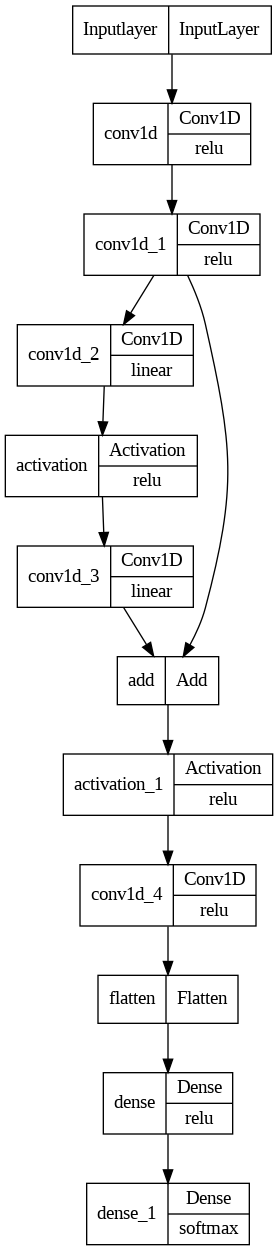

In [7]:
tf.keras.utils.plot_model(CNN_DDI(), show_layer_activations=True, to_file='model.png')

DDIMDL model referenced from "A multimodal deep learning framework for predicting drug-drug interaction events.[1]" Used to compare the result to the CNN model for the ablation studies.

In [8]:
# Code refrerenced from the paper "A multimodal deep learning framework
# for predicting drug-drug interaction events" github repository:
# https://github.com/YifanDengWHU/DDIMDL
def DNN():
    train_input = Input(shape=(vector_size * 2,), name='Inputlayer')
    train_in = Dense(512, activation='relu')(train_input)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(256, activation='relu')(train_in)
    train_in = BatchNormalization()(train_in)
    train_in = Dropout(droprate)(train_in)
    train_in = Dense(event_num)(train_in)
    out = Activation('softmax')(train_in)
    model = Model(inputs=train_input, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
print(DNN().summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Inputlayer (InputLayer)     [(None, 1144)]            0         
                                                                 
 dense_2 (Dense)             (None, 512)               586240    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                          

Function: `cross_validation`

Purpose

The `cross_validation` function is the main part for both spliting data and training on drug-drug interaction prediction tasks using a cross-validation methodology. It supports multiple types of classifiers, including the specifically designed CNN-DDI model and several traditional machine learning models.

Parameters

- **`feature_matrix`**: The input feature data for all drugs.
- **`label_matrix`**: The ground truth labels for the interactions.
- **`clf_type`**: Specifies the classifier type (e.g., CNNDDI, DDIMDL, RF, LR, etc.).
- **`event_num`**: The number of distinct drug-drug interaction events or classes.
- **`seed`**: Random seed for reproducibility of results.
- **`CV`**: The number of cross-validation folds.
- **`set_name`**: A descriptive name for the dataset being used (useful for debugging or tracking).

Operations

1. **Initialization**: Arrays for storing evaluation metrics and results are initialized.
2. **Cross-Validation Setup**: The data is split into `CV` number of folds. For each fold, data is partitioned into training and testing sets based on the indices determined by the `get_index` function.
3. **Model Training and Evaluation**:
   - For each classifier type (`clf_type`), the function configures the appropriate model:
     - **CNNDDI**: A convolutional neural network model is instantiated and trained on the training data. After training, predictions are made on the test set.
     - **DDIMDL**: A deep neural network model, defined in another part of the codebase, is similarly trained and evaluated.
     - **Traditional Classifiers (RF, GBDT, SVM, KNN, LR)**: For each of these classifiers, an instance is created, trained on the training data, and used to predict the test data. Probabilities or class labels are generated depending on the classifier's capability.
     - **Pretrained Models**: Optionally, a pretrained model can be loaded and used for prediction without retraining.
   - One-hot encoding is used for label encoding to fit the models' requirements.
   - Early stopping is implemented to prevent overfitting by monitoring the validation loss and stopping the training process if the loss does not improve.
4. **Aggregation of Results**: Predictions across all folds are aggregated. Evaluation metrics such as accuracy, precision, recall, and ROC-AUC scores are calculated for each fold and averaged.
5. **Returning Results**: The function returns the compiled results from all folds, including detailed metrics for each event type.

Return Values

- **`result_all`**: An array containing aggregated evaluation metrics across all classes.
- **`result_eve`**: An array containing detailed evaluation metrics for each event type separately.



In [9]:
def cross_validation(feature_matrix, label_matrix, clf_type, event_num, seed, CV, set_name):
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_true = np.array([])
    y_pred = np.array([])
    y_score = np.zeros((0, event_num), dtype=float)
    index_all_class = get_index(label_matrix, event_num, seed, CV)
    matrix = []
    if type(feature_matrix) != list:
        matrix.append(feature_matrix)
        feature_matrix = matrix
    for k in range(CV):
        print(k)
        train_index = np.where(index_all_class != k)
        test_index = np.where(index_all_class == k)
        pred = np.zeros((len(test_index[0]), event_num), dtype=float)
        for i in range(len(feature_matrix)):
            if clf_type == 'CNNDDI':
                x_train = feature_matrix[i][train_index]
                x_test = feature_matrix[i][test_index]
                y_train = label_matrix[train_index]
                # one-hot encoding
                y_train_one_hot = np.array(y_train)
                y_train_one_hot = (np.arange(y_train_one_hot.max() + 1) == y_train[:, None]).astype(dtype='float32')
                y_test = label_matrix[test_index]
                # one-hot encoding
                y_test_one_hot = np.array(y_test)
                y_test_one_hot = (np.arange(y_test_one_hot.max() + 1) == y_test[:, None]).astype(dtype='float32')
                cnn_ddi = CNN_DDI()
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
                cnn_ddi.fit(x_train, y_train_one_hot, batch_size=128, epochs=100, validation_data=(x_test, y_test_one_hot), callbacks=[early_stopping])
                pred += cnn_ddi.predict(x_test)
                break
            else:
                x_train = feature_matrix[i][train_index]
                x_test = feature_matrix[i][test_index]
                y_train = label_matrix[train_index]
                # one-hot encoding
                y_train_one_hot = np.array(y_train)
                y_train_one_hot = (np.arange(y_train_one_hot.max() + 1) == y_train[:, None]).astype(dtype='float32')
                y_test = label_matrix[test_index]
                # one-hot encoding
                y_test_one_hot = np.array(y_test)
                y_test_one_hot = (np.arange(y_test_one_hot.max() + 1) == y_test[:, None]).astype(dtype='float32')
                if clf_type == 'DDIMDL':
                    dnn = DNN()
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
                    dnn.fit(x_train, y_train_one_hot, batch_size=128, epochs=100, validation_data=(x_test, y_test_one_hot),
                            callbacks=[early_stopping])
                    pred += dnn.predict(x_test)
                    break
                elif clf_type == 'PRETRAINED':
                    loaded_model = keras.saving.load_model("model/CNNDDI.keras")
                    pred += loaded_model.predict(x_test)
                    break
                else:
                    if clf_type == 'RF':
                        clf = RandomForestClassifier(n_estimators=100)
                    elif clf_type == 'SVM':
                        clf = SVC(probability=True)
                    elif clf_type == 'FM':
                        clf = GradientBoostingClassifier()
                    elif clf_type == 'KNN':
                        clf = KNeighborsClassifier(n_neighbors=4)
                    else:
                        clf = LogisticRegression()
                    clf.fit(x_train, y_train)
                    pred += clf.predict_proba(x_test)
        pred_score = pred / len(feature_matrix)
        pred_type = np.argmax(pred_score, axis=1)
        y_true = np.hstack((y_true, y_test))
        y_pred = np.hstack((y_pred, pred_type))
        y_score = np.row_stack((y_score, pred_score))
    result_all, result_eve = evaluate(y_pred, y_score, y_true, event_num, set_name)
    return result_all, result_eve


def get_index(label_matrix, event_num, seed, CV):
    index_all_class = np.zeros(len(label_matrix))
    for j in range(event_num):
        index = np.where(label_matrix == j)
        kf = KFold(n_splits=CV, shuffle=True, random_state=seed)
        k_num = 0
        for train_index, test_index in kf.split(range(len(index[0]))):
            index_all_class[index[0][test_index]] = k_num
            k_num += 1

    return index_all_class

## Evaluation


Metrices used in this project:

* Accuracy: Measures the overall correctness of the model.
Precision: Ratio of true positive predictions to the total number of positive predictions made.
* Recall : Ratio of true positive predictions to the actual number of positive cases.
* F1 Score: Harmonic mean of precision and recall, providing a balance between them.
* ROC AUC (Area Under the Curve): Represents the likelihood of the model distinguishing between positive and negative classes.
* ROC AUPR (Area Under the Precision-Recall Curve): Focuses on the performance with respect to the positive class.


In [10]:
event_num = 65
droprate = 0.3
vector_size = 572


def evaluate(pred_type, pred_score, y_test, event_num, set_name):
    # print("Unique labels in y_test:", np.unique(y_test))
    # print("Expected number of events:", event_num)
    # if np.any(y_test >= event_num) or np.any(y_test < 0):
    #     raise ValueError("y_test contains labels outside the expected range based on event_num")
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_one_hot = label_binarize(y=y_test, classes=np.arange(event_num))
    pred_one_hot = label_binarize(y=pred_type, classes=np.arange(event_num))

    precision, recall, th = multiclass_precision_recall_curve(y_one_hot, pred_score)

    result_all[0] = accuracy_score(y_test, pred_type)
    result_all[1] = roc_aupr_score(y_one_hot, pred_score, average='micro')
    result_all[2] = roc_aupr_score(y_one_hot, pred_score, average='macro')
    result_all[3] = roc_auc_score(y_one_hot, pred_score, average='micro')
    result_all[4] = roc_auc_score(y_one_hot, pred_score, average='macro')
    result_all[5] = f1_score(y_test, pred_type, average='micro')
    result_all[6] = f1_score(y_test, pred_type, average='macro')
    result_all[7] = precision_score(y_test, pred_type, average='micro', zero_division=1)
    result_all[8] = precision_score(y_test, pred_type, average='macro', zero_division=1)
    result_all[9] = recall_score(y_test, pred_type, average='micro')
    result_all[10] = recall_score(y_test, pred_type, average='macro')

    for i in range(event_num):
        result_eve[i, 0] = accuracy_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel())
        result_eve[i, 1] = roc_aupr_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(), average=None)
        result_eve[i, 2] = roc_auc_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(), average=None)
        result_eve[i, 3] = f1_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(), average='binary')
        result_eve[i, 4] = precision_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(), average='binary', zero_division=1)
        result_eve[i, 5] = recall_score(y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel(), average='binary')
    return [result_all, result_eve]


def self_metric_calculate(y_true, pred_type):
    y_true = y_true.ravel()
    y_pred = pred_type.ravel()
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape((-1, 1))
    y_true_c = y_true.take([0], axis=1).ravel()
    y_pred_c = y_pred.take([0], axis=1).ravel()
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    for i in range(len(y_true_c)):
        if (y_true_c[i] == 1) and (y_pred_c[i] == 1):
            TP += 1
        if (y_true_c[i] == 1) and (y_pred_c[i] == 0):
            FN += 1
        if (y_true_c[i] == 0) and (y_pred_c[i] == 1):
            FP += 1
        if (y_true_c[i] == 0) and (y_pred_c[i] == 0):
            TN += 1
    print("TP=", TP, "FN=", FN, "FP=", FP, "TN=", TN)
    return (TP / (TP + FP), TP / (TP + FN))


def multiclass_precision_recall_curve(y_true, y_score):
    y_true = y_true.ravel()
    y_score = y_score.ravel()
    if y_true.ndim == 1:
        y_true = y_true.reshape((-1, 1))
    if y_score.ndim == 1:
        y_score = y_score.reshape((-1, 1))
    y_true_c = y_true.take([0], axis=1).ravel()
    y_score_c = y_score.take([0], axis=1).ravel()
    precision, recall, pr_thresholds = precision_recall_curve(y_true_c, y_score_c)
    return (precision, recall, pr_thresholds)


def roc_aupr_score(y_true, y_score, average="macro"):
    def _binary_roc_aupr_score(y_true, y_score):
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        sorted_indices = np.argsort(recall)
        sorted_recall = recall[sorted_indices]
        sorted_precision = precision[sorted_indices]
        return auc(sorted_recall, sorted_precision)

    def _average_binary_score(binary_metric, y_true, y_score, average):  # y_true= y_one_hot
        if average == "binary":
            return binary_metric(y_true, y_score)
        if average == "micro":
            y_true = y_true.ravel()
            y_score = y_score.ravel()
        if y_true.ndim == 1:
            y_true = y_true.reshape((-1, 1))
        if y_score.ndim == 1:
            y_score = y_score.reshape((-1, 1))
        n_classes = y_score.shape[1]
        score = np.zeros((n_classes,))
        for c in range(n_classes):
            y_true_c = y_true.take([c], axis=1).ravel()
            y_score_c = y_score.take([c], axis=1).ravel()
            score[c] = binary_metric(y_true_c, y_score_c)
        return np.average(score)

    return _average_binary_score(_binary_roc_aupr_score, y_true, y_score, average)



def save_result(feature_name, result_type, clf_type, result):
    with open(feature_name + '_' + result_type + '_' + clf_type+ '.csv', "w", newline='') as csvfile:
        writer = csv.writer(csvfile)
        for i in result:
            writer.writerow(i)
    return 0



## Main Function

In [11]:
def main(args):
    seed = 0
    CV = 5
    conn = sqlite3.connect("event.db")
    df_drug = pd.read_sql('select * from drug;', conn)
    print(df_drug.shape)
    feature_list = args['featureList']
    featureName = "+".join(feature_list)
    clf_list = args['classifier']
    for feature in feature_list:
        set_name = feature + '+'
    set_name = set_name[:-1]
    result_all = {}
    result_eve = {}
    all_matrix = []
    drugList = []
    for line in open("DrugList.txt", 'r'):
        drugList.append(line.split()[0])

    extraction = pd.read_sql('select * from extraction;', conn)
    mechanism = extraction['mechanism']
    action = extraction['action']
    drugA = extraction['drugA']
    drugB = extraction['drugB']


    for feature in feature_list:
        print(feature)
        new_feature, new_label, event_num = prepare(df_drug, [feature], vector_size, mechanism, action, drugA, drugB)
        all_matrix.append(new_feature)

    start = time.perf_counter()

    for clf in clf_list:
        print(clf)
        all_result, each_result = cross_validation(all_matrix, new_label, clf, event_num, seed, CV, set_name)
        save_result(featureName, 'all', clf, all_result)
        save_result(featureName, 'each', clf, each_result)
        result_all[clf] = all_result
        result_eve[clf] = each_result
    print("Time used:", time.perf_counter() - start)


To run the code with different models and feature selections, simply change the selection in the `args` and run `main(args)`

In [ ]:
#  featureList: A selection of features to be used.
#     The optional features are smile(substructure),target,enzyme
#     and pathway of the drugs.
#  classifier: A selection of prediction method to be used.
#     The optional methods are CNN-DDI, DDIMDL, RF, KNN and LR.
args = {
    'featureList': ["target", "enzyme"],
    'classifier': ["CNNDDI"]
}
main(args)

(572, 7)
target
enzyme
CNNDDI
0
Epoch 1/100
233/233 [==============================] - 32s 129ms/step - loss: 1.2505 - accuracy: 0.6361 - val_loss: 0.7479 - val_accuracy: 0.7572
Epoch 2/100
233/233 [==============================] - 27s 117ms/step - loss: 0.5890 - accuracy: 0.7994 - val_loss: 0.5996 - val_accuracy: 0.7937
Epoch 3/100
233/233 [==============================] - 27s 117ms/step - loss: 0.4313 - accuracy: 0.8474 - val_loss: 0.5661 - val_accuracy: 0.8016
Epoch 4/100
233/233 [==============================] - 27s 117ms/step - loss: 0.3455 - accuracy: 0.8742 - val_loss: 0.5735 - val_accuracy: 0.8111
Epoch 5/100
233/233 [==============================] - 27s 117ms/step - loss: 0.2905 - accuracy: 0.8927 - val_loss: 0.5636 - val_accuracy: 0.8204
Epoch 6/100
233/233 [==============================] - 27s 116ms/step - loss: 0.2523 - accuracy: 0.9070 - val_loss: 0.5989 - val_accuracy: 0.8166
Epoch 7/100
233/233 [==============================] - 27s 116ms/step - loss: 0.2279 - accur

# Results


You can download all output csv with following codes

In [13]:
%%capture
!gdown 1M5_1nSGHRjBwhsd9WHQEbmV7yH1g17BH
!unzip Results.zip

## Table of Results

In [14]:
csv_paths = [
    "pathway_all_CNNDDI.csv",
    "target_all_CNNDDI.csv",
    "enzyme_all_CNNDDI.csv",
    "pathway+enzyme_all_CNNDDI.csv",
    "target+enzyme_all_CNNDDI.csv",
    "pathway+target_all_CNNDDI.csv",
    "pathway+enzyme+target_all_CNNDDI.csv"
]

labels = [
    "Accuracy",
    "ROC AUPR (Micro)",
    "ROC AUPR (Macro)",
    "ROC AUC (Micro)",
    "ROC AUC (Macro)",
    "F1 Score (Micro)",
    "F1 Score (Macro)",
    "Precision (Micro)",
    "Precision (Macro)",
    "Recall (Micro)",
    "Recall (Macro)"
]

all_data = []
for path in csv_paths:
    df = pd.read_csv(path, header=None)
    df.columns = [path.split('/')[-1].split('_')[0]]
    df.index = labels
    all_data.append(df)

combined_df = pd.concat(all_data, axis=1)
print(combined_df)

                    pathway    target    enzyme  pathway+enzyme  \
Accuracy           0.808797  0.816713  0.660047        0.811963   
ROC AUPR (Micro)   0.892931  0.897247  0.741003        0.895303   
ROC AUPR (Macro)   0.725265  0.739179  0.431846        0.726414   
ROC AUC (Micro)    0.996970  0.997022  0.990990        0.997066   
ROC AUC (Macro)    0.987175  0.986826  0.968081        0.986383   
F1 Score (Micro)   0.808797  0.816713  0.660047        0.811963   
F1 Score (Macro)   0.683777  0.711834  0.412187        0.694384   
Precision (Micro)  0.808797  0.816713  0.660047        0.811963   
Precision (Macro)  0.737422  0.760167  0.541030        0.758507   
Recall (Micro)     0.808797  0.816713  0.660047        0.811963   
Recall (Macro)     0.652005  0.684757  0.378691        0.667015   

                   target+enzyme  pathway+target  pathway+enzyme+target  
Accuracy                0.822912        0.807643               0.809897  
ROC AUPR (Micro)        0.903479        0.89256


| Feature   | Accuracy | AUPR    | AUC     | F1 Score | Precision | Recall  |
|-----------|----------|---------|---------|----------|-----------|---------|
| T         | 0.816713 | 0.739179 | 0.986826 | 0.711834 | 0.760167  | 0.684757 |
| P         | 0.808797 | 0.725265 | 0.987175 | 0.683777 | 0.737422  | 0.652005 |
| E         | 0.660047 | 0.431846 | 0.968081 | 0.412187 | 0.541030  | 0.378691 |
| T + P     | 0.807643 | 0.722797 | 0.985203 | 0.697534 | 0.756161  | 0.669506 |
| T + E     | 0.822912 | 0.750684 | 0.989121 | 0.721712 | 0.784317  | 0.692193 |
| P + E     | 0.811963 | 0.726414 | 0.986383 | 0.694384 | 0.758507  | 0.667015 |
| T + P + E | 0.809897 | 0.728012 | 0.987393 | 0.695531 | 0.743660  | 0.666543 |

**Table 1: Performance Metrics of CNN-DDI Using Various Feature Combinations Based on My Data**

| Feature   | Accuracy | AUPR   | AUC    | F1 Score | Precision | Recall |
|-----------|----------|--------|--------|----------|-----------|--------|
| T         | 0.7915   | 0.847  | 0.9953 | 0.6099   | 0.6932    | 0.5716 |
| P         | 0.782    | 0.8381 | 0.9952 | 0.5805   | 0.6822    | 0.5364 |
| E         | 0.658    | 0.7098 | 0.9897 | 0.3344   | 0.4419    | 0.2957 |
| T + P     | 0.8227   | 0.8898 | 0.9969 | 0.6778   | 0.7589    | 0.6375 |
| T + E     | 0.8242   | 0.8712 | 0.9956 | 0.636    | 0.7373    | 0.5849 |
| P + E     | 0.8255   | 0.8747 | 0.9958 | 0.6227   | 0.713     | 0.5781 |
| T + P + E | 0.8243   | 0.869  | 0.9947 | 0.6489   | 0.7332    | 0.6063 |

**Table 2: Published Results of CNN-DDI Using Different Features from the Original Study (rows with feature C excluded) [2]**


**Analysis of Experimental Results**

In the tables provided, various performance metrics are listed, including Accuracy (ACC), area under the precision-recall curve (AUPR), area under the ROC curve (AUC), F1-score, Precision, and Recall. These metrics evaluate the model's ability to correctly predict drug-drug interactions (DDIs) using different sets of drug features: Targets (T), Pathways (P), Enzymes (E), and combinations.

From the tables, it's evident that the combination of two features (T + E) generally achieves the best results, highlighted by the highest scores across almost all metrics. This suggests that integrating multiple types of drug information helps capture a more comprehensive signal for predicting DDIs, thus enhancing model performance. I also noticed AUPR and AUC has a relative high value, which are crucial for evaluating the model's effectiveness in imbalanced datasets. The combination of Targets and Pathways (T + P) also shows strong performance, particularly in enhancing Precision and F1-score, suggesting that these features together capture essential interaction signals.

**Comparison with Published Data**

Comparing these results to those from the original paper, we observe a close alignment in the performance trends, indicating a successful replication of the study. Both datasets show that models utilizing a combination of features outperform those with single feature, underscoring the robustness and reproducibility of the CNN-DDI model. However, there are slight variations in the exact numerical values of the metrics, which could be attributed to differences in experimental conditions, such as model initialization, training procedures, or minor variations in dataset preprocessing.


## Model comparison

In [15]:
csv_paths = [
    "target+enzyme_all_CNNDDI.csv",
    "target+enzyme_all_RF.csv",
    "target+enzyme_all_KNN.csv",
    "target+enzyme_all_LR.csv"
]

csv_paths2 = ["target+enzyme_all_CNNDDI.csv", "target+enzyme_all_DDIMDL.csv"]

all_data = []
for path in csv_paths:
    df = pd.read_csv(path, header=None)
    df.columns = [path.split('/')[-1].split('_')[-1][:-4]]
    df.index = labels
    all_data.append(df)

combined_df = pd.concat(all_data, axis=1)
print(combined_df)

all_data = []
for path in csv_paths2:
    df = pd.read_csv(path, header=None)
    df.columns = [path.split('/')[-1].split('_')[-1][:-4]]
    df.index = labels
    all_data.append(df)

combined_df = pd.concat(all_data, axis=1)
print(combined_df)

                     CNNDDI        RF       KNN        LR
Accuracy           0.822912  0.734757  0.670164  0.729390
ROC AUPR (Micro)   0.903479  0.804984  0.728160  0.782121
ROC AUPR (Macro)   0.750684  0.581335  0.555193  0.570726
ROC AUC (Micro)    0.997242  0.992924  0.966299  0.993200
ROC AUC (Macro)    0.989121  0.965006  0.896084  0.978581
F1 Score (Micro)   0.822912  0.734757  0.670164  0.729390
F1 Score (Macro)   0.721712  0.490705  0.431758  0.370150
Precision (Micro)  0.822912  0.734757  0.670164  0.729390
Precision (Macro)  0.784317  0.745476  0.729708  0.800012
Recall (Micro)     0.822912  0.734757  0.670164  0.729390
Recall (Macro)     0.692193  0.420311  0.360030  0.317566
                     CNNDDI    DDIMDL
Accuracy           0.822912  0.827957
ROC AUPR (Micro)   0.903479  0.911749
ROC AUPR (Macro)   0.750684  0.762202
ROC AUC (Micro)    0.997242  0.996916
ROC AUC (Macro)    0.989121  0.989182
F1 Score (Micro)   0.822912  0.827957
F1 Score (Macro)   0.721712  0.727967


### Model Comparison 1

| Algorithm | ACC     | AUPR    | AUC     | F1      | Precision | Recall  |
|-----------|---------|---------|---------|---------|-----------|---------|
| CNN-DDI   | 0.82291 | 0.75068 | 0.98912 | 0.72171 | 0.78432   | 0.69219 |
| RF        | 0.73476 | 0.58134 | 0.96501 | 0.49071 | 0.74548   | 0.42031 |
| KNN       | 0.67016 | 0.55519 | 0.89608 | 0.43176 | 0.72971   | 0.36003 |
| LR        | 0.72939 | 0.57073 | 0.97858 | 0.37015 | 0.80001   | 0.31757 |

**Table 3: Evaluation Results of CNN-DDI and Other Models from Our Study**

| Algorithm | ACC    | AUPR   | AUC    | F1     | Precision | Recall |
|-----------|--------|--------|--------|--------|-----------|--------|
| CNN-DDI   | 0.8871 | 0.9251 | 0.998  | 0.7496 | 0.8556    | 0.722  |
| RF        | 0.7837 | 0.8446 | 0.9959 | 0.5167 | 0.6973    | 0.4444 |
| KNN       | 0.7581 | 0.8166 | 0.9881 | 0.625  | 0.7562    | 0.5596 |
| LR        | 0.7558 | 0.8087 | 0.995  | 0.3894 | 0.5617    | 0.3331 |

**Table 4: Published Evaluation Results of CNN-DDI and Other Models [2]**



**Analysis of the model comparison (ablation study)**

The data presented in the tables demonstrates a comparative analysis of the CNN-DDI model against traditional models such as Random Forest (RF), K-Nearest Neighbors (KNN), and Logistic Regression (LR) across various performance metrics. According to your results, CNN-DDI shows a distinct advantage in terms of accuracy, precision, recall, F1-score, and Area Under the Curve (AUC) compared to other models. For instance, CNN-DDI achieves the highest accuracy, precision, and recall scores, which are evident indicators of its superior performance in handling drug-drug interaction predictions. This supports Hypothesis 1, asserting that CNN-DDI outperforms traditional machine learning models in predicting drug-drug interactions, as it consistently delivers higher metrics across the board.


**Comparison with Published Data**

When comparing your results to those reported in the original paper, it's clear that both datasets exhibit similar trends where CNN-DDI surpasses traditional models. The comparative superiority of CNN-DDI over RF, KNN, and LR is consistent with the findings of the original paper, reinforcing the robustness of CNN-DDI in this domain and  validate the primary hypothesis of its enhanced performance in predicting DDIs.




### Model Comparison 2

| Algorithm | ACC     | AUPR    | AUC     | F1      | Precision | Recall  |
|-----------|---------|---------|---------|---------|-----------|---------|
| CNN-DDI   | 0.82291 | 0.75068 | 0.98912 | 0.72171 | 0.78432   | 0.69219 |
| DDIMLP    | 0.82796 | 0.76220 | 0.98918 | 0.72797 | 0.79905   | 0.69544 |

**Table 5: Evaluation Results of CNN-DDI and DDIMLP Model from Our Study**

| Algorithm | ACC    | AUPR   | AUC    | F1     | Precision| Recall |
|-----------|--------|--------|--------|--------|----------|--------|
| CNN-DDI   | 0.8871 | 0.9251 | 0.9980 | 0.7496 | 0.8556   | 0.7220 |
| DDIMLP    | 0.8852 | 0.9208 | 0.9976 | 0.7585 | 0.8471   | 0.7182 |

**Table 6: Published Evaluation Results of CNN-DDI and DDIMLP Model [2]**

**Analysis of CNN-DDI versus DDIMDL Comparison**

In examining the performance of CNN-DDI against DDIMDL across both my experimental data and the published results, it is evident that both models exhibit strong performance metrics. In my study, while DDIMDL slightly outperforms CNN-DDI in terms of AUPR, F1, and precision, CNN-DDI maintains competitive scores close to those of DDIMDL, especially in accuracy and AUC. This observation suggests a marginal difference between the two models when applying them to predict drug-drug interactions. Despite this, the evidence does not conclusively support Hypothesis 2 in my dataset as the improvements by DDIMDL in some metrics indicate that CNN-DDI might not universally outperform DDIMDL.

**Comparison to Published Data**

Comparing my results to those in the published data, both studies show CNN-DDI and DDIMDL performing similarly well, with CNN-DDI having a slight edge in certain metrics in the published study. However, in my data, this trend does not hold as strongly. I suspect that the reason my metrics are relatively lower than the published results is because the paper utilizes a combined dataset from DrugBank, while my dataset was generated using a different feature category approach. This variance in data sources and preparation could explain the discrepancies observed. Nevertheless, the close performance of the two models across both datasets underscores the robustness of CNN-DDI, though it does not conclusively confirm its superiority over DDIMDL in all aspects as initially hypothesized.




# Discussion

**Reproducibility and Challenges**

The paper is reproducible. Initially, I encountered some confusion due to references linking to another paper, the DDIMLP study, which shares a close methodological relationship with the CNN-DDI paper. This initially misled me about the specific implementations and datasets employed. However, upon deeper investigation and comparison of performance statistics, it became apparent that the current study's data might be a variant or extension of the DDIMLP dataset, which clarified the model's applicability and the experimental setup.

**Recommendations for Improved Reproducibility**

For researchers reproducing this paper, I recommend thoroughly reviewing the DDIMLP.py script available in the DDIMLP repository. Understanding its preprocessing, feature engineering, and modeling steps is crucial. However, this script lacks comprehensive documentation and updates to keep pace with newer library versions, which poses a barrier. More detailed comments and an updated codebase aligned with the latest Python packages would significantly aid in comprehension and ease the replication process.

**What Was Easy**

The CNN-DDI paper itself was articulate and clear, making it accessible not just to seasoned researchers but also to newcomers to the field. The direct presentation of concepts and results in the paper made it straightforward to grasp the theoretical underpinnings and practical implications of the study.

**What Was Difficult**

Adapting the DDIMLP's code to modern computational frameworks was challenging due to compatibility issues with newer versions of libraries. The absence of access to the exact DrugBank dataset used in the original study compelled me to modify the model and adapt the feature set, which may have impacted the accuracy of my results. The organization and lack of comments in the DDIMLP.py script also added to the complexity, requiring significant effort to decipher and implement the necessary computational steps. Something also difficult is doing this project solo. This is the first solo project I ever done and without chances dicussing with peer, I could wasily get stuck for days. Besides, I have to train all models sequentially which take a lot of time.

# References

[1] Deng, Y., Xu, X., Qiu, Y., Xia, J., Zhang, W., & Liu, S. (2020). A multimodal deep learning framework for predicting drug-drug interaction events. Bioinformatics (Oxford, England), 36(15), 4316–4322. https://doi.org/10.1093/bioinformatics/btaa501

[2] Zhang, C., Lu, Y. & Zang, T. CNN-DDI: a learning-based method for predicting drug–drug interactions using convolution neural networks. BMC Bioinformatics 23 (Suppl 1), 88 (2022). https://doi.org/10.1186/s12859-022-04612-2

[3] DrugBank. https://go.drugbank.com/